### Audio Load by Barney

In [1]:
from loading_augmenting_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)

Adding labels


100%|██████████| 413/413 [00:00<00:00, 516934.51it/s]


In [4]:
y = df['label']

In [5]:
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)

Finding longest file (Better Labels)


100%|██████████| 413/413 [00:07<00:00, 52.10it/s]


Loading files


100%|██████████| 413/413 [00:06<00:00, 59.08it/s]


In [6]:
augmented_audio = augment_audio(audio_files)

Augmenting Non-noise


100%|██████████| 413/413 [00:01<00:00, 391.45it/s]


Making noise


100%|██████████| 413/413 [00:08<00:00, 47.80it/s]


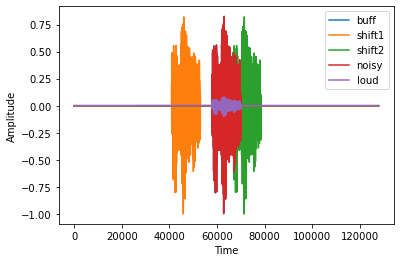

In [7]:
plot_sample(augmented_audio,100)

In [8]:
stfts = calc_stft(augmented_audio)

Augmentation  1


100%|██████████| 413/413 [00:02<00:00, 152.14it/s]


Augmentation  2


100%|██████████| 413/413 [00:02<00:00, 154.73it/s]


Augmentation  3


100%|██████████| 413/413 [00:02<00:00, 152.93it/s]


Augmentation  4


100%|██████████| 413/413 [00:02<00:00, 146.09it/s]


Augmentation  5


100%|██████████| 413/413 [00:02<00:00, 138.66it/s]


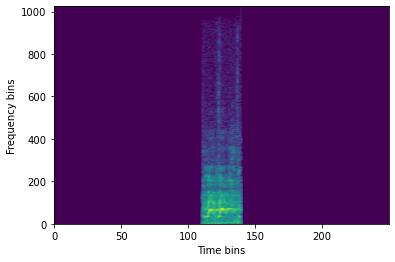

In [9]:
spec_plot(stfts[4,55,:,:])

### Data preparation

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.
/Users/jhn949/opt/anaconda3/envs/appml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jhn949/opt/anaconda3/envs/appml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jhn949/opt/anaconda3/envs/appml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/j

In [62]:
# Split in train and validation subsets
train_images, val_images, train_labels, val_labels = train_test_split(stfts[0], y, test_size=0.3, random_state=13052020)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 1025, 250 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
onehot_t = pd.get_dummies(train_labels)
label_list = onehot_t.columns
train_labels = onehot_t.to_numpy()

onehot_v = pd.get_dummies(val_labels)
val_labels = onehot_v.to_numpy()

num_classes = len(label_list)

In [64]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)

Training set:
 > images: (289, 1025, 250, 1)
 > labels: (289, 4)
Validation set:
 > images: (124, 1025, 250, 1)
 > labels: (124, 4)


### Create architecture

In [65]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1025, 250, 32)     320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 512, 125, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 62, 64)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 62, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1015808)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

### Compile and train model

In [66]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=128,
                    epochs=3,
                    verbose=1,
                    validation_data=(val_images, val_labels))

2022-05-30 16:07:43.440821: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 16:07:43.441214: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 289 samples, validate on 124 samples
Epoch 1/3
289/289 [==============================] - 204s 705ms/step - loss: 3.8147 - categorical_accuracy: 0.4775 - val_loss: 0.4761 - val_categorical_accuracy: 0.9032
Epoch 2/3
289/289 [==============================] - 165s 570ms/step - loss: 0.9069 - categorical_accuracy: 0.8304 - val_loss: 0.1936 - val_categorical_accuracy: 0.9597
Epoch 3/3
289/289 [==============================] - 146s 505ms/step - loss: 0.3865 - categorical_accuracy: 0.8754 - val_loss: 0.3029 - val_categorical_accuracy: 0.9355


1st convolution layer:


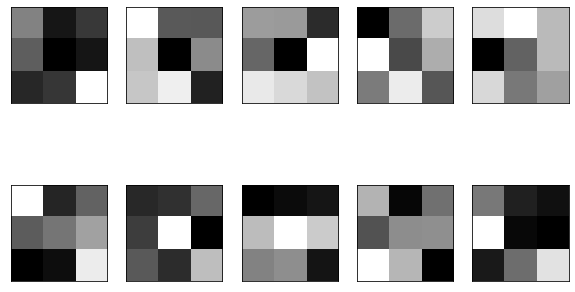

2nd convolution layer:


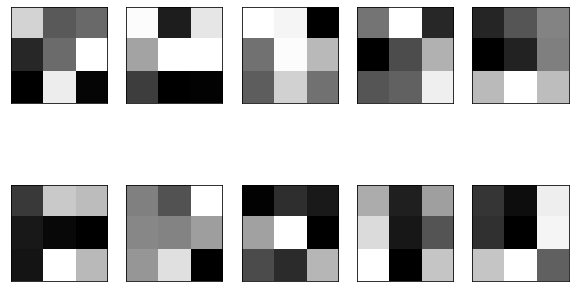

In [67]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

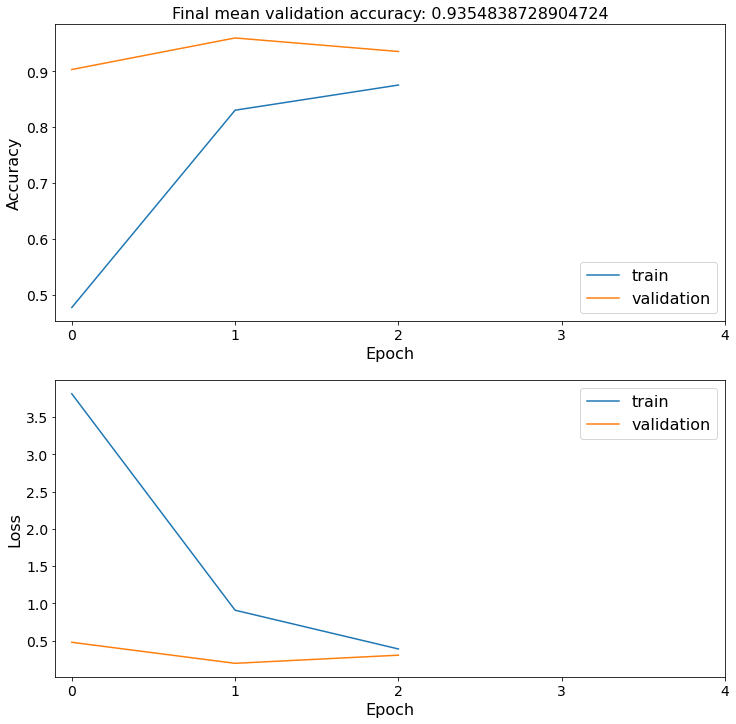

In [68]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

### Inference

In [69]:
# using until now unseen data
predicted_prob = model.predict(val_images)
predictions = np.argmax(predicted_prob, axis=1)

In [84]:
with tf.Session() as sess:
    confusion_matrix = tf.confusion_matrix(labels=np.argmax(val_labels, axis=1), predictions=predictions, num_classes=4)
    confusion_matrix_to_Print = sess.run(confusion_matrix)
    print(confusion_matrix_to_Print)
    
error_rate = (np.sum(confusion_matrix_to_Print)-np.sum(np.diag(confusion_matrix_to_Print))) / np.sum(np.diag(confusion_matrix_to_Print))
inf_acc = 1-error_rate
print('Error rate: ', error_rate)
print('Accuracy: ', inf_acc)

[[75  5  0  0]
 [ 1  0  0  0]
 [ 0  1  6  0]
 [ 0  0  1 35]]
Error rate:  0.06896551724137931
Accuracy:  0.9310344827586207
